In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

# sns.set()
# sns.set_theme()
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.style.use('dark_background')

import jax.numpy as jnp
from jax import random, vmap

import arviz as az
import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation


In [3]:
d = pd.read_csv("./data/Howell1.csv", sep=";", header=0)
d2 = d[d.age >= 18]

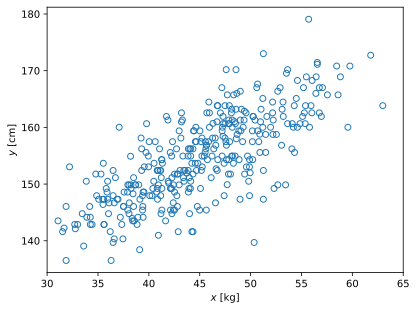

In [4]:
plt.plot(d2.weight, d2.height, "o", mfc='none')
plt.xlim([30, 65])
plt.ylabel("$y$ [cm]")
plt.xlabel("$x$ [kg]")
plt.savefig("../figures/ltsq1.svg")

m: 0.9050291086266492, c: 113.87939360689349


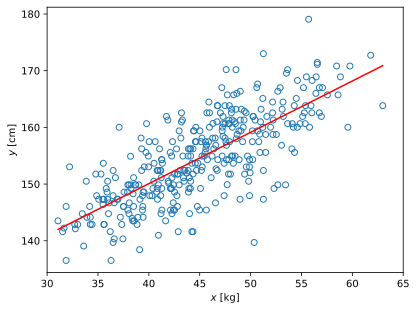

In [5]:
y = d2.height
x = d2.weight

A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]

plt.xlim([30, 65])
plt.plot(x, y, "o", mfc='none')
plt.plot(x,m*x + c, 'r', label='Fit')
plt.ylabel("$y$ [cm]")
plt.xlabel("$x$ [kg]")

print(f"m: {m}, c: {c}")

# plt.vlines(x,y,m*x+c)

plt.savefig("../figures/ltsq2.svg")

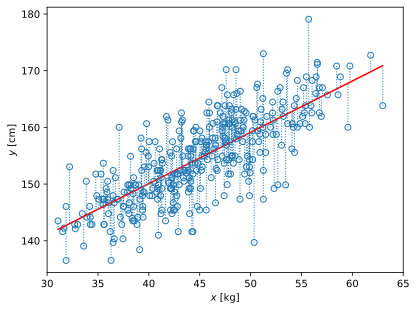

In [6]:
plt.plot(x, y, "o", mfc='none')
plt.xlim([30, 65])
plt.plot(x,m*x + c, 'r', label='Fit')
plt.ylabel("$y$ [cm]")
plt.xlabel("$x$ [kg]")

plt.vlines(x,y, m*x+c, linestyles='dotted', linewidth=1)

plt.savefig("../figures/ltsq3.svg")


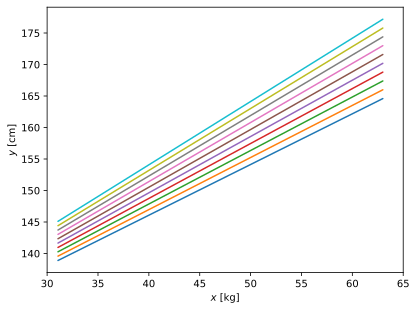

In [36]:
plt.xlim([30, 65])
for k in np.linspace(-0.1, 0.1, 10):
    plt.plot(x,(m+k)*x + c, label='Fit')
plt.ylabel("$y$ [cm]")
plt.xlabel("$x$ [kg]")


# plt.savefig("../figures/ltsq_mult_lines.svg")

---

In [7]:
# fit model
xbar = d2.weight.mean()

def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


In [8]:
m4_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_3,
    optim.Adam(1),
    Trace_ELBO(),
    weight=d2.weight.values,
    height=d2.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_3 = svi_result.params

100%|██████████| 2000/2000 [00:00<00:00, 9425.48it/s, init loss: 40631.5430, avg. loss [1901-2000]: 1078.9297]


In [9]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
mu_link = lambda weight: post["a"] + post["b"] * (weight - xbar)
weight_seq = jnp.arange(start=25, stop=71, step=1)
mu = vmap(mu_link)(weight_seq).T
mu_mean = jnp.mean(mu, 0)
mu_HPDI = hpdi(mu, prob=0.89, axis=0)

sim_height = Predictive(m4_3.model, post, return_sites=["height"])(
    random.PRNGKey(2), weight_seq, None
)["height"]
sim_height.shape, list(sim_height[:5, 0])

height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

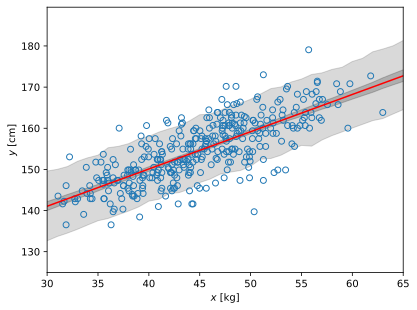

In [10]:
# plot raw data
# az.plot_pair(
#     d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
# )
plt.ylabel("$y$ [cm]")
plt.xlabel("$x$ [kg]")
plt.plot(x, y, "o", mfc='none')
# draw MAP line
plt.plot(weight_seq, mu_mean, "r")
plt.xlim([30, 65])

# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)
plt.savefig("../figures/ltsq_uncertainty.svg")

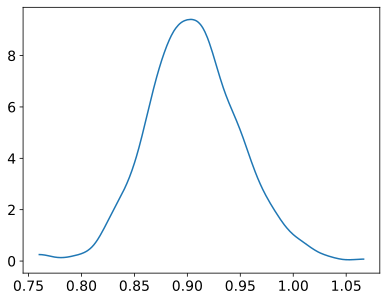

In [28]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
# mu_at_50 = post["a"] + post["b"] * (50 - xbar)
mu_at_50 = post["b"]

az.plot_kde(post["b"])
plt.savefig("../figures/ltsq_beta1_post.svg")